In [1]:
import snntorch as snn
from snntorch import surrogate
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import torch
from typing import Callable

In [2]:
import visualize
import dataset as ds
import SNN_func as snnfn

## Constants

In [3]:
nCublets = 1000
nSensors = 100
max_t = 20
dt = 0.2
timesteps = int(max_t/dt)

In [4]:
labels_map = {
  -1: "unclassified",
   0: "proton",
   1: "kaon",
   2: "pion",
   3: "other"
}
nClasses = len(labels_map)-1

## Network Parameters

### Architecture

In [5]:
# Network Descriptions

population = 20

net_desc = {
    "layers" : [400, 120, 120, population],
    "timesteps": 100,
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.2,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.atan(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.atan(),
                    }],
                3: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.atan(),
                    }]
                }
    }

#net_desc_membrane = deepcopy(net_desc)
#net_desc_membrane["output"] = "membrane"

net_desc_spikefreq = deepcopy(net_desc)
net_desc_spikefreq["output"] = "spike"

### Spike Generation

In [6]:
# Spike Generation

def _spikegen(data):
    spike_data = data.transpose(0,1) 
    spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
    return spike_train

def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

### Prediction

In [7]:
def predict_membrane(output):
    prediction = output[-1].squeeze(1)
    if len(prediction.shape) > 1:
        prediction = prediction.mean(1)
    return prediction

def predict_spikefreq(output):
    prediction = output.sum(0).mean(1) # sum spikes across time and average over the population
    return prediction

def distance(prediction, targets, absolute: bool = True, relative: bool = True,
             transform: Callable = lambda *args, **kwargs: args[0]):
    p, t = transform(prediction), transform(targets)
    accuracy = t - p
    if absolute:
        accuracy = torch.abs(accuracy)
    if relative:
        accuracy /= t
    return accuracy

def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a

# Dataset Creation

Change the path depending on which dataset you want to use.

In [8]:
dataset = ds.build_dataset("../Data/PrimaryOnly/Uniform", max_files=100, primary_only=True,
                           target=["energy","centroid","dispersion"])

### Check Distributions

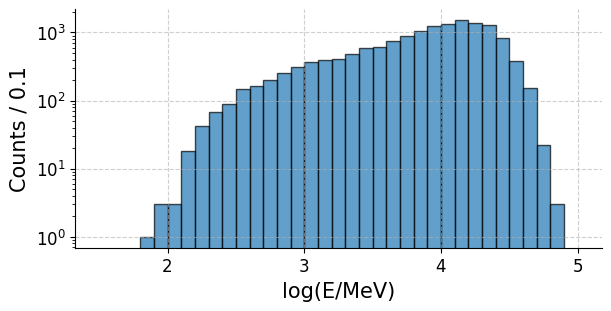

In [9]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1][0])), torch.float32)
dims=["log(E/MeV)"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(6*len(dims), 3),constrained_layout=True)     
n = 10
bins=np.arange(1.5, 5+1/n, 1/n)
axs.set_ylabel(f"Counts / {1/n}", fontsize=15)
for i in range(len(dims)):    
    energy = np.array([d[1] for d in dataset])
    axs.set_xlabel(dims[i], fontsize=15)
    axs.grid(True, linestyle='--', alpha=0.6)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_yscale('log')
        
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.set_xticks([i for i in range(7)])
    hist = axs.hist(energy, bins, edgecolor='black', alpha=0.7)


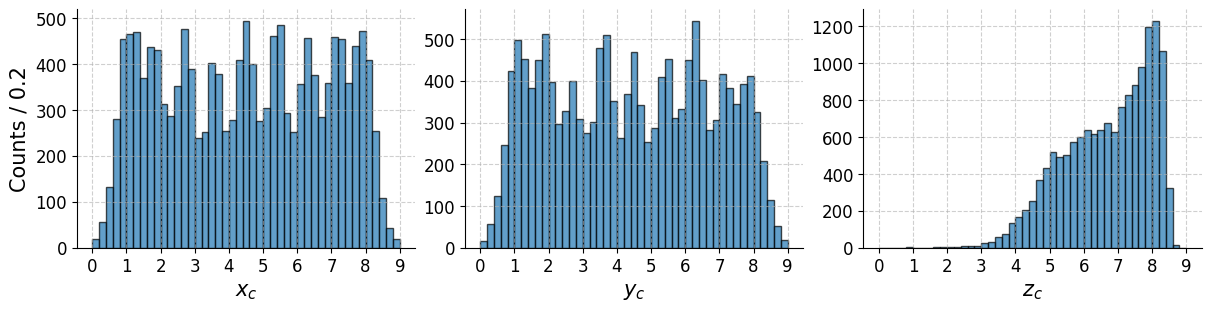

In [10]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1]), torch.float32)

dims=[r"$x_c$", r"$y_c$", r"$z_c$"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(4*len(dims), 3),constrained_layout=True)     
n = 5
bins=np.arange(0, 9+1/n, 1/n)
axs[0].set_ylabel(f"Counts / {1/n}", fontsize=15)
for i in range(len(dims)):    
    positions = np.array([d[1][i] for d in dataset])
    axs[i].set_xlabel(dims[i], fontsize=15)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    #axs[i].set_yscale('log')
        
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_xticks([i for i in range(10)])
    hist = axs[i].hist(positions, bins, edgecolor='black', alpha=0.7)


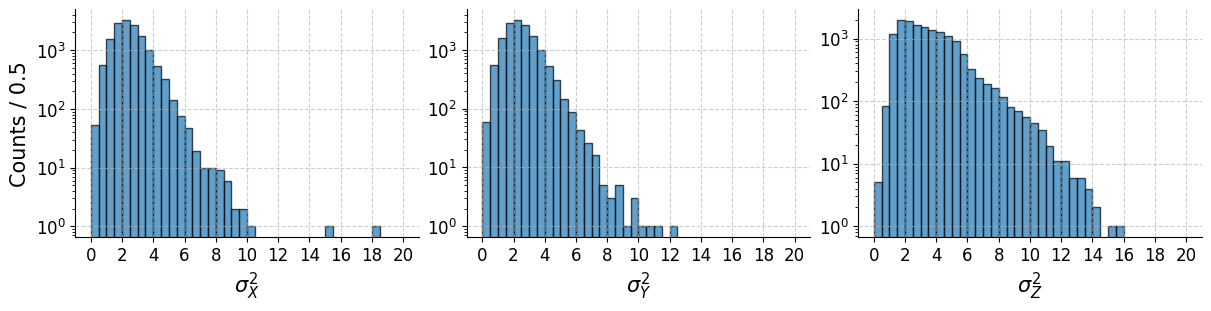

In [11]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2]), torch.float32)

dims=["X", "Y", "Z"]
fig, axs = plt.subplots(ncols=len(dims), nrows=1, facecolor="w", figsize=(4*len(dims), 3),constrained_layout=True)     
n = 2
bins=np.arange(0, 20+1/n, 1/n)
axs[0].set_ylabel(f"Counts / {1/n}", fontsize=15)
for i in range(len(dims)):    
    dispersions = np.array([d[1][i] for d in dataset])
    axs[i].set_xlabel(dims[i], fontsize=15)
    axs[i].grid(True, linestyle='--', alpha=0.6)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_yscale('log')
        
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].set_xticks([2*i for i in range(11)])
    hist = axs[i].hist(dispersions, bins, edgecolor='black', alpha=0.7)
    axs[i].set_xlabel(rf"$\sigma^2_{dims[i]}$")

# Train

## Energy and Position

In [12]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype([np.log10(x[1][0]), *x[1][1]], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

net_desc_spikefreq["layers"][-1] = 4*population

In [13]:
net_Epos_spk = snnfn.Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_Epos_spk = snnfn.Predictor(predict_spikefreq, distance, population_sizes=20)
loss_Epos = snnfn.multi_MSELoss(weights=torch.tensor([1,1,1,1]))
opt_Epos_spk = torch.optim.Adam(net_Epos_spk.parameters(), lr=1e-2, betas=(0.9, 0.999), weight_decay=1e-3)
sche_Epos_spk = torch.optim.lr_scheduler.ExponentialLR(opt_Epos_spk, gamma=0.7)
train_Epos_spk = snnfn.Trainer(net_Epos_spk, loss_Epos, opt_Epos_spk, Pred_Epos_spk,
                    train_dataset, val_dataset, test_dataset)

In [14]:
num_epochs = 5
train_Epos_spk.train(num_epochs)

Epoch 0:
Validation Loss = 27.246571901109483
Validation Average Error = [0.20442787 0.6816995  0.6176019         inf]

-------------------------------



ches:   0%|        | 0/210 [00:00<?, ?it/s]
ches:   0%| | 1/210 [00:00<01:31,  2.27it/s
ches:   1%| | 2/210 [00:00<01:27,  2.37it/s
ches:   1%| | 3/210 [00:01<01:13,  2.81it/s
ches:   2%| | 4/210 [00:01<01:07,  3.03it/s
ches:   2%| | 5/210 [00:01<01:06,  3.08it/s
ches:   3%| | 6/210 [00:02<01:03,  3.23it/s
ches:   3%| | 7/210 [00:02<01:02,  3.25it/s
ches:   4%| | 8/210 [00:02<01:01,  3.27it/s
ches:   4%| | 9/210 [00:02<00:58,  3.41it/s
ches:   5%| | 10/210 [00:03<00:59,  3.37it/
ches:   5%| | 11/210 [00:03<00:58,  3.39it/
ches:   6%| | 12/210 [00:03<00:57,  3.47it/
ches:   6%| | 13/210 [00:04<00:56,  3.48it/
ches:   7%| | 14/210 [00:04<00:55,  3.51it/
ches:   7%| | 15/210 [00:04<00:51,  3.80it/
ches:   8%| | 16/210 [00:04<00:52,  3.68it/
ches:   8%| | 17/210 [00:05<00:51,  3.76it/
ches:   9%| | 18/210 [00:05<00:52,  3.66it/
ches:   9%| | 19/210 [00:05<00:52,  3.61it/
ches:  10%| | 20/210 [00:05<00:55,  3.40it/
ches:  10%| | 21/210 [00:06<00:56,  3.36it/
ches:  10%| | 22/210 [00:06<00:5

Epoch 1:
Validation Loss = 4.480410697725084
Validation Average Error = [0.04054524 0.283607   0.57917225        inf]

-------------------------------




ches:   0%|        | 0/210 [00:00<?, ?it/s]
ches:   0%| | 1/210 [00:00<00:53,  3.90it/s
ches:   1%| | 2/210 [00:00<00:47,  4.35it/s
ches:   1%| | 3/210 [00:00<00:47,  4.32it/s
ches:   2%| | 4/210 [00:00<00:48,  4.23it/s
ches:   2%| | 5/210 [00:01<00:47,  4.28it/s
ches:   3%| | 6/210 [00:01<00:48,  4.17it/s
ches:   3%| | 7/210 [00:01<00:47,  4.27it/s
ches:   4%| | 8/210 [00:01<00:48,  4.19it/s
ches:   4%| | 9/210 [00:02<00:47,  4.22it/s
ches:   5%| | 10/210 [00:02<00:47,  4.17it/
ches:   5%| | 11/210 [00:02<00:46,  4.32it/
ches:   6%| | 12/210 [00:02<00:47,  4.21it/
ches:   6%| | 13/210 [00:03<00:46,  4.23it/
ches:   7%| | 14/210 [00:03<00:47,  4.15it/
ches:   7%| | 15/210 [00:03<00:45,  4.25it/
ches:   8%| | 16/210 [00:03<00:45,  4.24it/
ches:   8%| | 17/210 [00:04<00:45,  4.21it/
ches:   9%| | 18/210 [00:04<00:45,  4.21it/
ches:   9%| | 19/210 [00:04<00:45,  4.16it/
ches:  10%| | 20/210 [00:04<00:47,  3.98it/
ches:  10%| | 21/210 [00:05<00:47,  3.94it/
ches:  10%| | 22/210 [00:05<00:

Epoch 2:
Validation Loss = 2.7863133483462863
Validation Average Error = [0.04160124 0.23753785 0.39711463        inf]

-------------------------------




ches:   0%|        | 0/210 [00:00<?, ?it/s]
ches:   0%| | 1/210 [00:00<00:47,  4.41it/s
ches:   1%| | 2/210 [00:00<00:48,  4.30it/s
ches:   1%| | 3/210 [00:00<00:44,  4.61it/s
ches:   2%| | 4/210 [00:00<00:46,  4.38it/s
ches:   2%| | 5/210 [00:01<00:47,  4.32it/s
ches:   3%| | 6/210 [00:01<00:49,  4.15it/s
ches:   3%| | 7/210 [00:01<00:47,  4.30it/s
ches:   4%| | 8/210 [00:01<00:46,  4.32it/s
ches:   4%| | 9/210 [00:02<00:46,  4.36it/s
ches:   5%| | 10/210 [00:02<00:44,  4.51it/
ches:   5%| | 11/210 [00:02<00:43,  4.58it/
ches:   6%| | 12/210 [00:02<00:43,  4.55it/
ches:   6%| | 13/210 [00:02<00:42,  4.63it/
ches:   7%| | 14/210 [00:03<00:42,  4.56it/
ches:   7%| | 15/210 [00:03<00:41,  4.69it/
ches:   8%| | 16/210 [00:03<00:41,  4.66it/
ches:   8%| | 17/210 [00:03<00:41,  4.62it/
ches:   9%| | 18/210 [00:04<00:42,  4.47it/
ches:   9%| | 19/210 [00:04<00:42,  4.51it/
ches:  10%| | 20/210 [00:04<00:41,  4.53it/
ches:  10%| | 21/210 [00:04<00:41,  4.54it/
ches:  10%| | 22/210 [00:04<00:

Epoch 3:
Validation Loss = 2.4983443366156686
Validation Average Error = [0.04257243 0.24951649 0.3750434         inf]

-------------------------------




ches:   0%|        | 0/210 [00:00<?, ?it/s]
ches:   0%| | 1/210 [00:00<00:46,  4.54it/s
ches:   1%| | 2/210 [00:00<00:49,  4.22it/s
ches:   1%| | 3/210 [00:00<00:53,  3.89it/s
ches:   2%| | 4/210 [00:01<00:53,  3.86it/s
ches:   2%| | 5/210 [00:01<00:51,  4.00it/s
ches:   3%| | 6/210 [00:01<00:51,  4.00it/s
ches:   3%| | 7/210 [00:01<00:50,  4.04it/s
ches:   4%| | 8/210 [00:01<00:49,  4.04it/s
ches:   4%| | 9/210 [00:02<00:49,  4.06it/s
ches:   5%| | 10/210 [00:02<00:49,  4.04it/
ches:   5%| | 11/210 [00:02<00:48,  4.12it/
ches:   6%| | 12/210 [00:02<00:47,  4.14it/
ches:   6%| | 13/210 [00:03<00:47,  4.13it/
ches:   7%| | 14/210 [00:03<00:47,  4.08it/
ches:   7%| | 15/210 [00:03<00:47,  4.07it/
ches:   8%| | 16/210 [00:03<00:47,  4.08it/
ches:   8%| | 17/210 [00:04<00:47,  4.03it/
ches:   9%| | 18/210 [00:04<00:45,  4.25it/
ches:   9%| | 19/210 [00:04<00:46,  4.10it/
ches:  10%| | 20/210 [00:04<00:47,  4.01it/
ches:  10%| | 21/210 [00:05<00:48,  3.94it/
ches:  10%| | 22/210 [00:05<00:

Epoch 4:
Validation Loss = 2.561244993739658
Validation Average Error = [0.06832096 0.33352444 0.35840106        inf]

-------------------------------




ches:   0%|        | 0/210 [00:00<?, ?it/s]
ches:   0%| | 1/210 [00:00<00:49,  4.22it/s
ches:   1%| | 2/210 [00:00<00:49,  4.17it/s
ches:   1%| | 3/210 [00:00<00:48,  4.28it/s
ches:   2%| | 4/210 [00:00<00:47,  4.30it/s
ches:   2%| | 5/210 [00:01<00:48,  4.23it/s
ches:   3%| | 6/210 [00:01<00:48,  4.22it/s
ches:   3%| | 7/210 [00:01<00:49,  4.07it/s
ches:   4%| | 8/210 [00:01<00:49,  4.09it/s
ches:   4%| | 9/210 [00:02<00:49,  4.04it/s
ches:   5%| | 10/210 [00:02<00:47,  4.20it/
ches:   5%| | 11/210 [00:02<00:49,  4.03it/
ches:   6%| | 12/210 [00:02<00:48,  4.06it/
ches:   6%| | 13/210 [00:03<00:48,  4.03it/
ches:   7%| | 14/210 [00:03<00:49,  3.97it/
ches:   7%| | 15/210 [00:03<00:45,  4.30it/
ches:   8%| | 16/210 [00:03<00:44,  4.33it/
ches:   8%| | 17/210 [00:04<00:44,  4.35it/
ches:   9%| | 18/210 [00:04<00:44,  4.29it/
ches:   9%| | 19/210 [00:04<00:41,  4.57it/
ches:  10%| | 20/210 [00:04<00:41,  4.56it/
ches:  10%| | 21/210 [00:04<00:42,  4.50it/
ches:  10%| | 22/210 [00:05<00:

Epoch 5:
Validation Loss = 2.4735032108094956
Validation Average Error = [0.04873174 0.26464048 0.37905505        inf]

-------------------------------



Test loss: 3.1576281070709227
Test relative error: [ 8.129008 31.563616 47.608166  9.045496]%


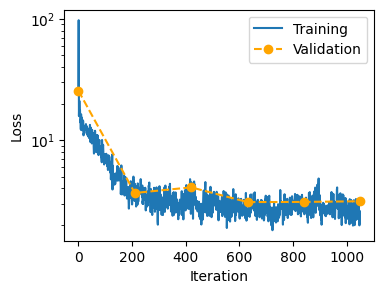

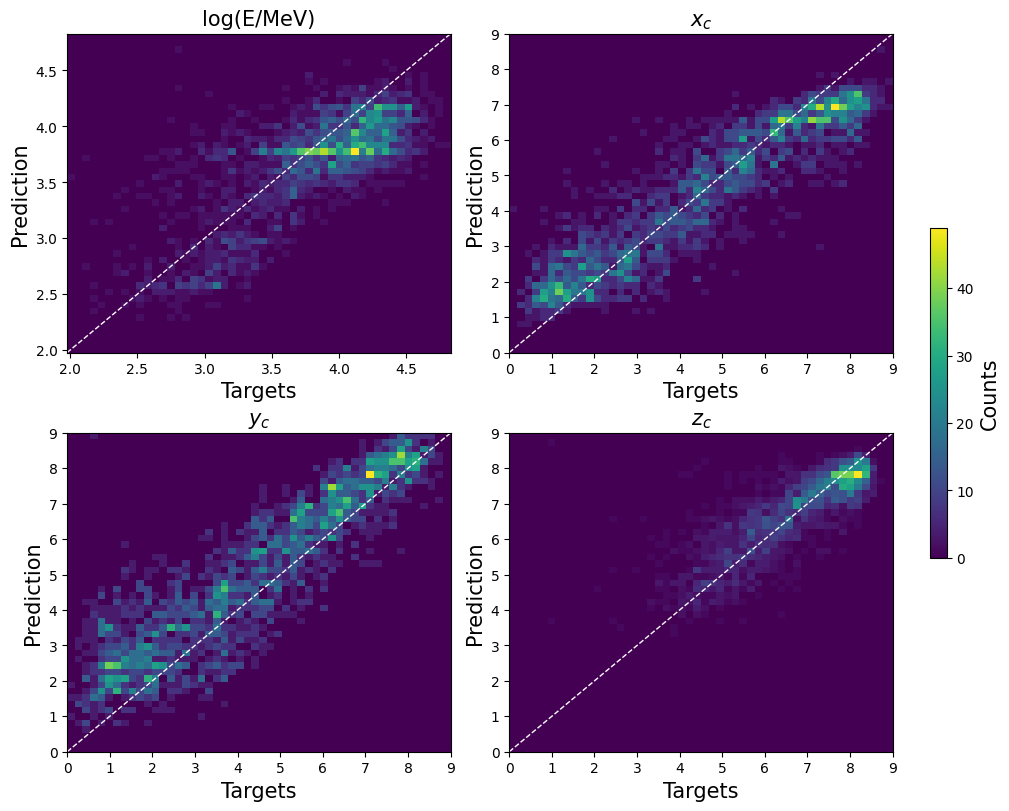

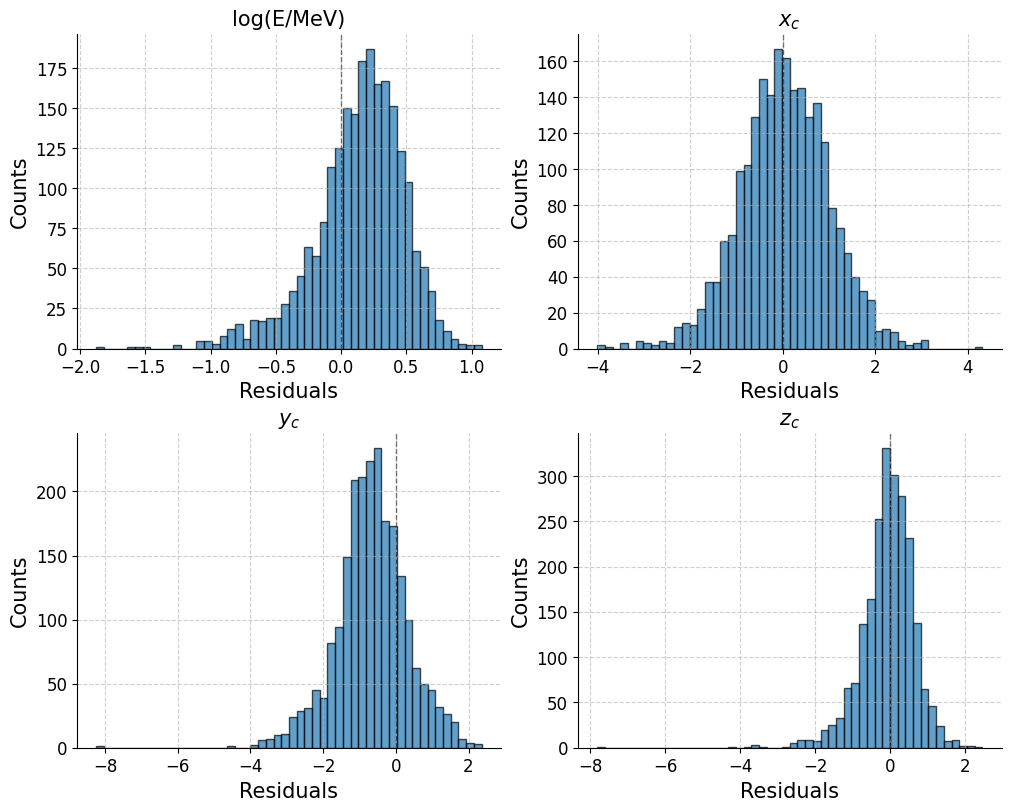

In [33]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_Epos_spk.test("test")
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_Epos_spk.show_results(nbins=50, title=["log(E/MeV)", r"$x_c$", r"$y_c$", r"$z_c$"])

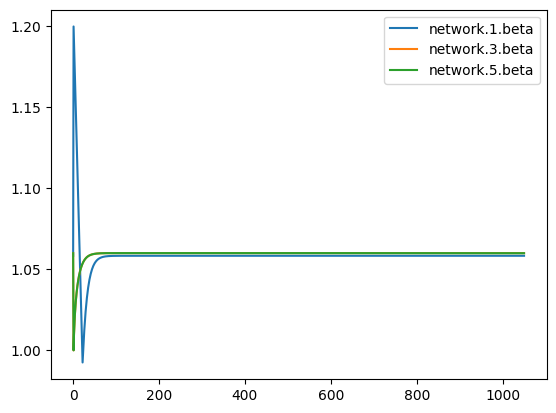

In [16]:
history_of_parameters = train_Epos_spk.get_par_hist()

#print(history_of_parameters.keys())
for key, item in history_of_parameters.items():
    if "weight" not in key and "bias" not in key:
        if "beta" in key:
            plt.plot(np.arange(0, len(item)), item, label=key)
            plt.legend()


In [ ]:
plt.plot(np.arange(0, len(history_of_parameters[history_of_parameters.keys()[0]])), history_of_parameters[history_of_parameters.keys()[0]], label=history_of_parameters.keys()[0])


In [16]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_Epos_spk.test("test")
print(f"Test relative error: {train_Epos_spk.acc_hist['test'][train_Epos_spk.current_epoch]}")

Test relative error: [0.08067514 0.48747253 0.7708443  0.25557974]


Test loss: 1.2372003025478786
Test relative error: [-3.1926012e+05  4.4578662e+00 -5.9305911e+00  1.8966553e+01]%


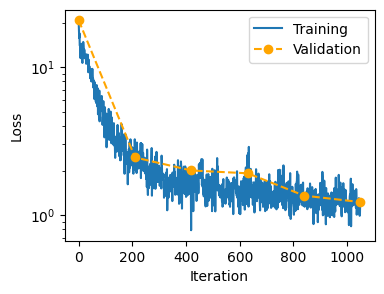

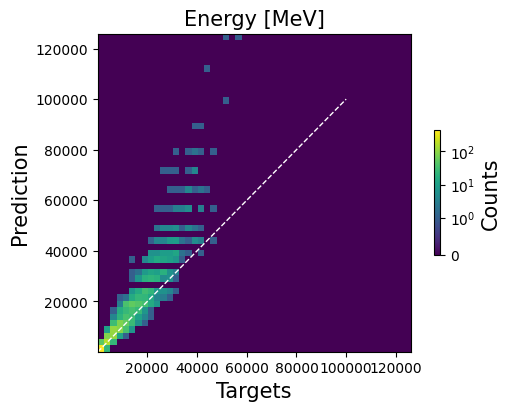

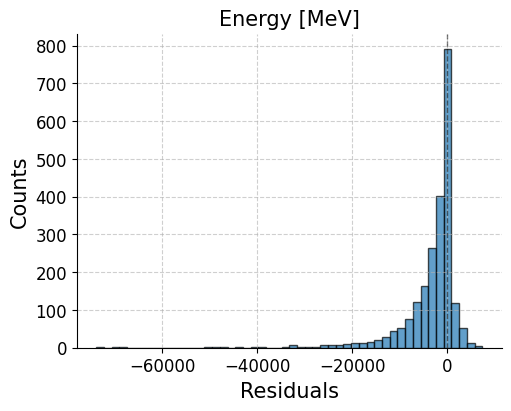

In [38]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False, transform=antitransform)

train_Epos_spk.test("test")
train_Epos_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Energy [MeV]",
                            select=[0], transform=antitransform)

In [18]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True, transform=antitransform)
train_Epos_spk.test("test")
print(f"Test relative error: {train_Epos_spk.acc_hist['test'][train_Epos_spk.current_epoch]*100}%")

Test relative error: [17.826584 19.874136 36.264565  4.129561]%


In [19]:
train_Epos_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False, transform=antitransform)
train_Epos_spk.test("test")
print(f"Test relative error: {train_Epos_spk.acc_hist['test'][train_Epos_spk.current_epoch]}")

Test relative error: [1.9456113e+03 4.8744813e-01 7.7158415e-01 2.5539219e-01]


# NOT UPDATED CODE BELOW! RUN AT YOUR OWN RISK!

# Energy and Dispersion

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype([np.log10(x[1][0]), *x[1][2]], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

net_desc_spikefreq["layers"][-1] = 4*population

In [ ]:
net_Esigma_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_Esigma_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_Esigma = multi_MSELoss(weights=torch.tensor([1,1,1,1]), set_mse=[0,0,0,0])
opt_Esigma_spk = torch.optim.Adam(net_Esigma_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_Esigma_spk = torch.optim.lr_scheduler.ExponentialLR(opt_Esigma_spk, gamma=0.7)
train_Esigma_spk = Trainer(net_Esigma_spk, loss_Esigma, opt_Esigma_spk, Pred_Esigma_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_Esigma_spk.train(num_epochs)

In [ ]:
train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_Esigma_spk.test("test")
train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_Esigma_spk.show_results(nbins=50, title=["log-E", r"$\sigma^2_x$", r"$\sigma^2_y$", r"$\sigma^2_z$"])

In [ ]:
train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_Esigma_spk.test("test")
print(f"Test relative error: {train_Esigma_spk.acc_hist['test'][train_Esigma_spk.current_epoch]}")

In [ ]:
def antitransform(x):
    a = x.clone() 
    a[:, 0] = torch.pow(10, a[:,0])
    return a

train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False, transform=antitransform)

train_Esigma_spk.test("test")
train_Esigma_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Energy [MeV]",
                            select=[0], transform=antitransform)

In [ ]:
train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True, transform=antitransform)
train_Esigma_spk.test("test")
print(f"Test relative error: {train_Esigma_spk.acc_hist['test'][train_Esigma_spk.current_epoch]*100}%")

In [ ]:
train_Esigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False, transform=antitransform)
train_Esigma_spk.test("test")
print(f"Test relative error: {train_Esigma_spk.acc_hist['test'][train_Esigma_spk.current_epoch]}")

# Dispersion

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_desc_spikefreq["layers"][-1] = 90
net_sigma_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_sigma_spk = Predictor(predict_spikefreq, distance, population_sizes=30)
loss_sigma = multi_MSELoss(weights=torch.tensor([1,1,1]))
opt_sigma_spk = torch.optim.Adam(net_sigma_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sigma_spk = Trainer(net_sigma_spk, loss_sigma, opt_sigma_spk, Pred_sigma_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_sigma_spk.train(num_epochs)

In [ ]:
f = r"$\sigma_X$"
"sigma" in f

In [ ]:
train_sigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_sigma_spk.test("test")
train_sigma_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_sigma_spk.show_results(nbins=50, title=[r"$\sigma_X$", r"$\sigma_Y$", r"$\sigma_Z$"])

# Particle Classification

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data", max_files=5, target="particle")

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
from collections import Counter
Counter([d[1] for d in data_train])

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps)

In [ ]:
def comp_accuracy(output, targets):
    _, predicted = output.sum(dim=0).max(1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()

    return predicted, correct/total

In [ ]:
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_net = Trainer(net, loss_fn, optimizer, train_load, val_load, test_load, comp_accuracy)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.plot_loss()

In [ ]:
train_net.test("test", mc=True, num_classes=nClasses)
print(train_net.loss_hist["test"])
train_net.cm["test"].plot()

# Energy Regression

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_E_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_E = nn.L1Loss()
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_E_spk = torch.optim.lr_scheduler.ExponentialLR(opt_E_spk, gamma=0.7)
train_E_spk = Trainer(net_E_spk, loss_E, opt_E_spk, Pred_E_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_E_spk.train(num_epochs)

In [ ]:
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_E_spk.test("test")
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_E_spk.show_results(nbins=50, title="log(E/MeV)")

In [ ]:
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_E_spk.test("test")
print(f"Test relative error: {train_E_spk.acc_hist['test'][train_E_spk.current_epoch]}")

In [ ]:
def expon(x):
    return torch.pow(10, x)
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True, transform=expon)
train_E_spk.test("test")
print(f"Test relative error: {train_E_spk.acc_hist['test'][train_E_spk.current_epoch]*100}%")

In [ ]:
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False, transform=expon)
train_E_spk.test("test")
print(f"Test relative error: {train_E_spk.acc_hist['test'][train_E_spk.current_epoch]}")

In [ ]:
train_E_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False, transform=expon)
train_E_spk.show_results(nbins=50, title="E [MeV]", transform=expon, logscale=True, linthresh=1)

# X

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1][0], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_X_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_X_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_X = nn.MSELoss()
opt_X_spk = torch.optim.Adam(net_X_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_X_spk = torch.optim.lr_scheduler.ExponentialLR(opt_X_spk, gamma=0.7)
train_X_spk = Trainer(net_X_spk, loss_X, opt_X_spk, Pred_X_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_X_spk.train(num_epochs)

In [ ]:
train_X_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_X_spk.test("test")
train_X_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_X_spk.show_results(nbins=50, title=r"$x_c$")

In [ ]:
train_X_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_X_spk.test("test")
print(f"Test relative error: {train_X_spk.acc_hist['test'][train_X_spk.current_epoch]}")

# Y

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1][1], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_Y_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_Y_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_Y = nn.MSELoss()
opt_Y_spk = torch.optim.Adam(net_Y_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_Y_spk = torch.optim.lr_scheduler.ExponentialLR(opt_Y_spk, gamma=0.7)
train_Y_spk = Trainer(net_Y_spk, loss_Y, opt_Y_spk, Pred_Y_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_Y_spk.train(num_epochs)

In [ ]:
train_Y_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_Y_spk.test("test")
train_Y_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_Y_spk.show_results(nbins=50, title=r"$y_c$")

In [ ]:
train_Y_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_Y_spk.test("test")
print(f"Test relative error: {train_Y_spk.acc_hist['test'][train_Y_spk.current_epoch]}")

# Z

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][1][2], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_Z_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_Z_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_Z = nn.L1Loss()
opt_Z_spk = torch.optim.Adam(net_Z_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_Z_spk = torch.optim.lr_scheduler.ExponentialLR(opt_Z_spk, gamma=0.7)
train_Z_spk = Trainer(net_Z_spk, loss_Z, opt_Z_spk, Pred_Z_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_Z_spk.train(num_epochs)

In [ ]:
train_Z_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_Z_spk.test("test")
train_Z_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_Z_spk.show_results(nbins=50, title=r"$z_c$")

In [ ]:
train_Z_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_Z_spk.test("test")
print(f"Test relative error: {train_Z_spk.acc_hist['test'][train_Z_spk.current_epoch]}")

# Sigma X

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2][0], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_sigmaX_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_sigmaX_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_sigmaX = nn.L1Loss()
opt_sigmaX_spk = torch.optim.Adam(net_sigmaX_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_sigmaX_spk = torch.optim.lr_scheduler.ExponentialLR(opt_sigmaX_spk, gamma=0.7)
train_sigmaX_spk = Trainer(net_sigmaX_spk, loss_sigmaX, opt_sigmaX_spk, Pred_sigmaX_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_sigmaX_spk.train(num_epochs)

In [ ]:
train_sigmaX_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_sigmaX_spk.test("test")
train_sigmaX_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_sigmaX_spk.show_results(nbins=50, title=r"$\sigma^2_x$")

In [ ]:
train_sigmaX_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_sigmaX_spk.test("test")
print(f"Test relative error: {train_sigmaX_spk.acc_hist['test'][train_sigmaX_spk.current_epoch]}")

# Sigma Y

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2][0], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
net_sigmaY_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_sigmaY_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_sigmaY = nn.L1Loss()
opt_sigmaY_spk = torch.optim.Adam(net_sigmaY_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_sigmaY_spk = torch.optim.lr_scheduler.ExponentialLR(opt_sigmaY_spk, gamma=0.7)
train_sigmaY_spk = Trainer(net_sigmaY_spk, loss_sigmaY, opt_sigmaY_spk, Pred_sigmaY_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_sigmaY_spk.train(num_epochs)

In [ ]:
train_sigmaY_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_sigmaY_spk.test("test")
train_sigmaY_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_sigmaY_spk.show_results(nbins=50, title=r"$\sigma^2_y$")

In [ ]:
train_sigmaY_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_sigmaY_spk.test("test")
print(f"Test relative error: {train_sigmaY_spk.acc_hist['test'][train_sigmaY_spk.current_epoch]}")

# Sigma Z

In [ ]:
dataset.transform = lambda x: (x[0], ds.to_tensor_and_dtype(x[1][2][2], torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

net_desc_spikefreq["layers"][-1] = 1*population

In [ ]:
net_sigmaZ_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_sigmaZ_spk = Predictor(predict_spikefreq, distance, population_sizes=20)
loss_sigmaZ = nn.L1Loss()
opt_sigmaZ_spk = torch.optim.Adam(net_sigmaZ_spk.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=1e-3)
sche_sigmaZ_spk = torch.optim.lr_scheduler.ExponentialLR(opt_sigmaZ_spk, gamma=0.7)
train_sigmaZ_spk = Trainer(net_sigmaZ_spk, loss_sigmaZ, opt_sigmaZ_spk, Pred_sigmaZ_spk,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_sigmaZ_spk.train(num_epochs)

In [ ]:
train_sigmaZ_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=True)
train_sigmaZ_spk.test("test")
train_sigmaZ_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=False, relative=False)
train_sigmaZ_spk.show_results(nbins=50, title=r"$\sigma^2_z$")

In [ ]:
train_sigmaZ_spk.predict.accuracy_fn = lambda p, t: distance(p, t, absolute=True, relative=False)
train_sigmaZ_spk.test("test")
print(f"Test relative error: {train_sigmaZ_spk.acc_hist['test'][train_sigmaZ_spk.current_epoch]}")

### Membrane Potential

In [ ]:
net_E_mem = Spiking_Net(net_desc_membrane, lambda x: spikegen_multi(x,4)) 
Pred = Predictor(predict_membrane)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
optimizer = torch.optim.Adam(net_E_mem.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net = Trainer(net_E_mem, loss_fn, optimizer, Pred,
                    train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_net.train(num_epochs)

In [ ]:
train_net.test("test")
train_net.show_results(nbins=50)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)
train_net.predict.transform = antitransform

train_net.test("test")
train_net.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

In [ ]:
train_net.test("test")
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_loss()
train_net.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net.test("test", transform=antitransform)
print(f"Test loss: {train_net.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net.acc_hist['test'][num_epochs]*100}%")
train_net.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

### SpikeFreq

In [ ]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4)) 
Pred_E_spk = Predictor(predict_spikefreq)
loss_fn = nn.MSELoss() #multi_MSELoss(weights=torch.tensor([1]))
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, Pred_E_spk,
                      train_dataset, val_dataset, test_dataset)

In [ ]:
num_epochs = 5
train_E_spk.train(num_epochs)

In [ ]:
train_E_spk.test("test")
train_E_spk.show_results(nbins=50)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)
train_E_spk.predict.transform = antitransform

train_E_spk.test("test")
train_E_spk.show_results(nbins=50, logscale=True, linthresh=1, title="Total Energy [MeV]")

In [ ]:
net_E_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_E_spk = torch.optim.Adam(net_E_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_E_spk = Trainer(net_E_spk, loss_fn, opt_E_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_E_spk.train(num_epochs)

train_E_spk.test("test")
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_loss()
train_E_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_E_spk.test("test", transform=antitransform)
print(f"Test loss: {train_E_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_E_spk.acc_hist['test'][num_epochs]*100}%")
train_E_spk.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_dataset:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E_spk(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

### Linear Model

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2", max_files=5, primary_only=True,
                                                   target=["energy", "centroid"])

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/All", max_files=100, primary_only=False,
                                                   target=["energy", "centroid"])

In [ ]:
lin_model     = LinearRegression()
lin_model_log = LinearRegression()

x, y = zip(*[data_train[i] for i in range(len(data_train))])
E = np.array([y[0] for y in y])
centroid = np.array([y[1] for y in y])
#primary = np.array([y[2] for y in y])

# Convert to NumPy arrays
x = torch.stack(x).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x > 0
x = x[mask]
E = E[mask]
centroid = centroid[mask]
#primary = primary[mask]

# convert to double log scale
x_log = np.log10(x)
E_log = np.log10(E)

lin_model.fit(x.reshape(-1,1), E)
lin_model_log.fit(x_log.reshape(-1,1), E_log)
print("Linear Model:")
print("Slope:", lin_model.coef_[0])
print("Intercept:", lin_model.intercept_)
print("\n###################\n\nLinear Model Trained on logs:")
print("Slope:", lin_model_log.coef_[0])
print("Intercept:", lin_model_log.intercept_)

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("log(Energy [MeV])")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(E_log)

In [ ]:
x_test, y_test = zip(*[data_train[i] for i in range(len(data_test))])
E_test = np.array([y[0] for y in y_test])
centroid_test = np.array([y[1] for y in y_test])
#primary_test = np.array([y[2] for y in y_test])

# Convert to NumPy arrays
x_test = torch.stack(x_test).sum((1,2)).numpy()  # Convert features to NumPy

# eliminate results with no photons
mask = x_test > 0
x_test = x_test[mask]
E_test = E_test[mask]
centroid_test = centroid_test[mask]
#primary_test = primary_test[mask]

x_test_log = np.log10(x_test)
E_test_log = np.log10(E_test)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

x_plot = np.arange(0.1, np.max(x_test), 1e3)
y_plot = lin_model.predict(x_plot.reshape(-1,1))
x_plot_log = np.arange(0.1, np.max(x_test_log), 0.1)
y_plot_log = lin_model_log.predict(x_plot_log.reshape(-1,1))

ax[0].set_xlabel("log(Photon Count)")
ax[0].set_ylabel("log(Energy [MeV])")
hb0 = ax[0].hist2d(x_test_log, E_test_log, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[0].plot(np.log10(x_plot), np.log10(y_plot), color='white',
           linewidth=2, linestyle='--', label="Linear Model Prediction")
ax[0].plot(x_plot_log, y_plot_log, color='#FF00FF',
           linewidth=2, linestyle='--', label="Log Model Prediction")
cbar0 = fig.colorbar(hb0[3], ax=ax[0])
cbar0.set_label('Data')  # Label for the first colorbar
ax[0].legend()

ax[1].set_xlabel("Photon Count")
ax[1].set_ylabel("Energy [MeV]")
hb1 = ax[1].hist2d(x_test, E_test, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
cbar1 = fig.colorbar(hb1[3], ax=ax[1])
cbar1.set_label('Data')  # Label for the first colorbar
ax[1].legend()

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

condition = centroid_test[:,1] < 5

ax[0].set_title("Y idx < 5")
ax[0].set_ylabel("Energy [MeV]")
hb0 = ax[0].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[0].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[0].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[0].legend()


condition = centroid_test[:,1] >= 5

ax[1].set_title("Y idx >= 5")
hb1 = ax[1].hist2d(x_test[condition], E_test[condition], 50, norm=SymLogNorm(linthresh=1, vmax=1e4, vmin=0), cmap='viridis')
ax[1].plot(x_plot, y_plot, color='white',
           linewidth=1, linestyle='--', label="Linear Model Prediction")
ax[1].plot(np.pow(10,x_plot_log), np.pow(10,y_plot_log), color='#FF00FF',
           linewidth=1, linestyle='--', label="Log Model Prediction")
ax[1].legend()

cbar1 = fig.colorbar(hb1[3], ax=ax)
cbar1.set_label('Data') 
fig.text(0.5, 0.04, 'Photon Count', ha='center')
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
E_pred = lin_model.predict(x_test.reshape(-1,1))
acc = np.mean(abs((E_test-E_pred)/E_test)*100)
print(f"Mean relative error: {acc}%")

In [ ]:
E_pred_log = lin_model_log.predict(x_test_log.reshape(-1,1))
acc = np.mean(abs((np.pow(10,E_test_log)-np.pow(10,E_pred_log))/np.pow(10,E_test_log))*100)
print(f"Mean relative error: {acc}%")

In [ ]:
mask_up   = E_test_log > lin_model_log.predict(x_test_log.reshape(-1,1))
mask_down = E_test_log < lin_model_log.predict(x_test_log.reshape(-1,1))

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.hist(centroid_test[mask_up, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='blue', facecolor='white', linewidth=1.5, label='E > prediction', alpha=0.8)
ax.hist(centroid_test[mask_down, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='orange', facecolor='white', linewidth=1.5, label='E < prediction', alpha=0.8)
ax.hist(centroid_test[:, 1], bins=[-0.5+i for i in range(11)], 
        edgecolor='grey', facecolor='lightgrey', alpha=0.2, linewidth=1.5, label='Global')
ax.set_xticks([i for i in range(10)])
ax.legend()
ax.set_xlabel("Centroid Y cell")
ax.set_ylabel("Counts per cell")

# Energy Centroid

## X

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
X = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("X coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(X)

In [ ]:
net_x_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_x_spk = torch.optim.Adam(net_x_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_x_spk = Trainer(net_x_spk, loss_fn, opt_x_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_x_spk.train(num_epochs)

train_x_spk.test("test")
print(f"Test loss: {train_x_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_x_spk.acc_hist['test'][num_epochs]*100}%")
train_x_spk.plot_loss()
train_x_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
Z = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Z coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Z, bins=[i for i in range(10)])

In [ ]:
net_z_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_z_spk = torch.optim.Adam(net_z_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_z_spk = Trainer(net_z_spk, loss_fn, opt_z_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_z_spk.train(num_epochs)

train_z_spk.test("test")
print(f"Test loss: {train_z_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_z_spk.acc_hist['test'][num_epochs]*100}%")
train_z_spk.plot_loss()
train_z_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
Y = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel("Y coordinate")
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Y, bins=[i for i in range(10)])

In [ ]:
net_y_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
opt_y_spk = torch.optim.Adam(net_y_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_y_spk = Trainer(net_y_spk, loss_fn, opt_y_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_y_spk.train(num_epochs)

train_y_spk.test("test")
print(f"Test loss: {train_y_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_y_spk.acc_hist['test'][num_epochs]*100}%")
train_y_spk.plot_loss()
train_y_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## X, Y and Z together

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [ ]:
set_seed(12)
a = torch.rand(size=(100,5,30))
b = torch.rand(size=(5,3))
p, a = predict_spikefreq_multitask(a, b)
print(p.shape, a.shape)
t = torch.rand(size=(5,3))
print(t)
print(p)
loss_fn = nn.MSELoss(reduction='sum')
o = loss_fn(t, p)
print(o)

In [ ]:
population = 10
net_centroid = {
    "layers" : [400, 200, 3*population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

def predict_spikefreq_multitask(output, targets, transform=None):
    population=10
    output = output.reshape(output.shape[0], output.shape[1], population, -1)
    prediction = output.sum((0,2))/(output.shape[0]*output.shape[2])
    if transform:
        prediction, targets = transform(prediction), transform(targets)
    accuracy = torch.abs((targets - prediction)/targets)
    return prediction, torch.mean(accuracy, 0)

net_c = Spiking_Net(net_centroid, lambda x: spikegen_multi(x,4))

loss_fn = nn.MSELoss()
optimizer_c = torch.optim.Adam(net_c.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_c = Trainer(net_c, loss_fn, optimizer_c, train_load, val_load, test_load, predict_spikefreq_multitask)

In [ ]:
train_net_c.train(5)

In [ ]:
train_net_c.acc_hist["validation"]

# Energy Dispersion

## X

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][0]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaX = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{X}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaX)

#print(f"Minimum energy: {min(energies)}")

In [ ]:
net_sX_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sX_spk = torch.optim.Adam(net_sX_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sX_spk = Trainer(net_sX_spk, loss_fn, opt_sX_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sX_spk.train(num_epochs)

train_sX_spk.test("test")
print(f"Test loss: {train_sX_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sX_spk.acc_hist['test'][num_epochs]*100}%")
train_sX_spk.plot_loss()
train_sX_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Z

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][2]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaZ = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Z}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaZ)

In [ ]:
net_sZ_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sZ_spk = torch.optim.Adam(net_sZ_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sZ_spk = Trainer(net_sZ_spk, loss_fn, opt_sZ_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sZ_spk.train(num_epochs)

train_sZ_spk.test("test")
print(f"Test loss: {train_sZ_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sZ_spk.acc_hist['test'][num_epochs]*100}%")
train_sZ_spk.plot_loss()
train_sZ_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

## Y

In [ ]:
dataset.transform = transform=lambda x: (x[0], ds.to_tensor_and_dtype((x[1][2][1]), torch.float32))
train_dataset, test_dataset, val_dataset = ds.build_loaders(dataset, (0.7, 0.15), shuffle=True, num_workers=0)

In [ ]:
sigmaY = ((np.array([d[1] for d in dataset])))

fig = plt.figure(facecolor="w", figsize=(4, 3))
plt.xlabel(r'$\sigma_{Y}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(sigmaY)

In [ ]:
net_sY_spk = Spiking_Net(net_desc_spikefreq, lambda x: spikegen_multi(x,4))

opt_sY_spk = torch.optim.Adam(net_sY_spk.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_sY_spk = Trainer(net_sY_spk, loss_fn, opt_sY_spk, train_dataset, val_dataset, test_dataset, predict_spikefreq)

In [ ]:
num_epochs=5
train_sY_spk.train(num_epochs)

train_sY_spk.test("test")
print(f"Test loss: {train_sY_spk.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_sY_spk.acc_hist['test'][num_epochs]*100}%")
train_sY_spk.plot_loss()
train_sY_spk.plot_pred_vs_target(50, logscale=False, linthresh=1)

# Energy Regression + Y Position

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly2",  primary_only=True, target="energy",
                                                   transform=lambda x: (x[0], ds.to_tensor_and_dtype(np.log10(x[1]), torch.float32)))

batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
def spikegen_multi(data, multiplicity=4):
    og_shape = data.shape
    spike_data = torch.zeros(og_shape[1], og_shape[0], multiplicity*og_shape[2])
    for i in range(multiplicity):
        condition = data > np.power(10, i+2)
        batch_idx, time_idx, sensor_idx = torch.nonzero(condition, as_tuple=True)
        spike_data[time_idx, batch_idx, multiplicity*sensor_idx+i] = 1

    return spike_data

def spikegen_with_position(data, *args, **kwargs):
    spk1 = spikegen_multi(data, *args, **kwargs)
    spk2 = net_y(data)

    output = torch.cat((spk1, spk2), dim=2)

    return output


population = 10
net_desc_spikefreq_with_pos = {
    "layers" : [410, 200, population],
    "timesteps": 100,
    "output": "membrane",
    "neuron_params" : {
                1: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True,
                    "spike_grad": surrogate.fast_sigmoid(),
                    }],
                2: [snn.Leaky, 
                    {"beta" : 1.0,
                    "learn_beta": True,
                    "threshold" : 1.0,
                    "learn_threshold": True, 
                    "spike_grad": surrogate.fast_sigmoid(),
                    }]
                }
    }

net_E = Spiking_Net(net_desc_spikefreq_with_pos, lambda x: spikegen_with_position(x,4))

optimizer_E = torch.optim.Adam(net_E.parameters(), lr=5e-4, betas=(0.9, 0.999))
train_net_E = Trainer(net_E, loss_fn, optimizer_E, train_load, val_load, test_load, predict_spikefreq)
    

In [ ]:
num_epochs=10
train_net_E.train(num_epochs)

train_net_E.test("test")
print(f"Test loss: {train_net_E.loss_hist['test'][10]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][10]*100}%")
train_net_E.plot_loss()
train_net_E.plot_pred_vs_target(50, logscale=False, linthresh=1)

In [ ]:
def antitransform(x):
    return torch.pow(10, x)

train_net_E.test("test", transform=antitransform)
print(f"Test loss: {train_net_E.loss_hist['test'][num_epochs]}")
print(f"Test relative error: {train_net_E.acc_hist['test'][num_epochs]*100}%")
train_net_E.plot_pred_vs_target(50, transform=antitransform, logscale=True, linthresh=1)

In [ ]:
net_E.eval()
all_x = []
all_predictions = []
with torch.no_grad():
    for data, targets in test_load:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        output = net_E(data)
        # calculate total accuracy
        pred, acc = predict_spikefreq(output, targets, antitransform)
        all_predictions.extend(pred.tolist())
        all_x.extend(data.sum((1,2)).tolist())
        
fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel("Photon Count")
plt.ylabel("Energy Prediction [MeV]")
plt.hist2d(all_x, all_predictions, 50, norm=SymLogNorm(linthresh=1), cmap='viridis')
# Add a color bar
plt.colorbar(label='Counts')
plt.plot([0, 1e5], [0, 1e5], color='white', linewidth=1, linestyle='--')

# N of interactions

In [ ]:
data_train, data_test, data_val = ds.build_dataset("../Data/PrimaryOnly", max_files=5, target="N_int",
                                                   transform= lambda x: (x[0], ds.to_tensor_and_dtype(x[1], torch.float32)))

In [ ]:
batch_size = 50
nw = 0
train_load = DataLoader(data_train[:(len(data_train)//batch_size)*batch_size], batch_size=batch_size, shuffle=True, num_workers=nw)
val_load   = DataLoader(data_val[:(len(data_val)//batch_size)*batch_size],     batch_size=batch_size, shuffle=True, num_workers=nw)
test_load  = DataLoader(data_test[:(len(data_test)//batch_size)*batch_size],   batch_size=batch_size, shuffle=True, num_workers=nw)

In [ ]:
Nint = ((np.array([d[1] for d in data_train])))

fig = plt.figure(facecolor="w", figsize=(10, 6))
plt.xlabel(r'$\sigma_{E}$', fontsize=14)
plt.ylabel("Counts")
plt.yscale("log")
plt.hist(Nint)


In [ ]:
min(Nint)

In [ ]:
idx = 15
print(Nint[idx])
visualize.plot_views(idx, data_train)

# OLD

In [ ]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0)

In [ ]:
class Net_Reg(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, timesteps,
                 learnable=True, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = 1                     # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1e20,
                                 learn_beta=learnable)
        
    def _spikegen(self, data):
        spike_data = data.transpose(0,1) 
        spike_train = torch.where(spike_data > 300, torch.tensor(1), torch.tensor(0)).to(torch.float32) 
        return spike_train
    
    def forward(self, data):
        """Forward pass for several time steps."""

        x = self._spikegen(data)

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return  mem2_rec[-1].squeeze(1)

In [ ]:
#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_steps = timesteps
net2 = Net_Reg(num_inputs, num_hidden, num_steps)

In [ ]:
def accuracy_set(net, data_loader, loss_fn, comp_mc=False):
    mcm = MulticlassConfusionMatrix(num_classes=nClasses, normalize='none')
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets)
            total += tot
            correct += corr
            if comp_mc:
                mcm.update(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total

        return mean_loss, acc, mcm

In [ ]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, batch_size=100):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            # forward pass
            output = net(spike_in)

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, batch_size)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

In [ ]:
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
net.train()

In [ ]:
num_epochs = 5
iter_counter = 0

#loss = nn.MSELoss()
num_inputs = 100
num_hidden = 200
num_outputs = nClasses
num_steps = timesteps
net = Net_LIF_1L(num_inputs, num_hidden, num_outputs, num_steps).to(device)
loss_fn = SF.ce_count_loss(num_classes=nClasses)
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

res = train_net(net, train_load, val_load, num_epochs, loss_fn, optimizer, batch_size=100)

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[0])
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(res[1])
plt.title("Validation loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
test = accuracy_set(net, test_load, loss_fn, True)
test[2].plot()

In [ ]:

for data, targets in train_load:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data)
            spike_in = spike_in.to(device)

            print(spike_in.shape)
            break